BERT(Bidirectional Encoder Representations from Transformers)는 2018년에 구글이 공개한 사전 훈련된 모델  

BERT의 문맥을 반영한 임베딩(Contextual Embedding)  
- 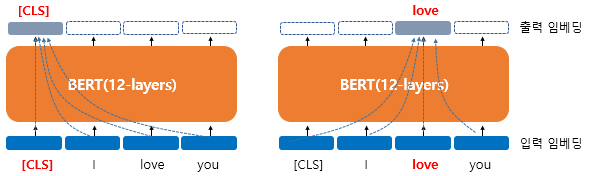  
- BERT의 입력은 임베딩 층(Embedding layer)를 지난 임베딩 벡터들이고 모든 단어들은 768차원의 임베딩 벡터가 되어 BERT의 입력으로 사용됨
- BERT는 내부적인 연산을 거친 후 동일하게 각 단어에 대해서 768차원의 벡터를 출력함
- BERT의 연산을 거친 후의 출력 임베딩은 문장의 문맥을 모두 참고한 문맥을 반영한 임베딩이 됨
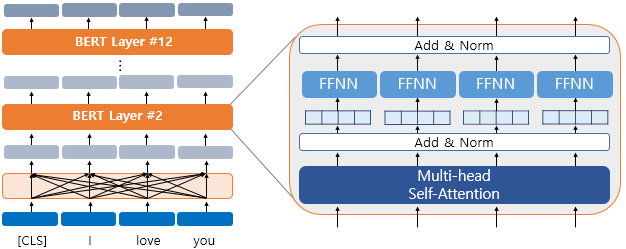  
- BERT는 기본적으로 트랜스포머 인코더를 12번 쌓은 것이므로 내부적으로 각 층마다 멀티 헤드 셀프 어텐션과 포지션 와이즈 피드 포워드 신경망을 수행함

BERT의 subword 토크나이저 : WordPiece  

- 단어보다 더 작은 단위로 쪼개는 subword 토크나이저를 사용함
- BERT가 사용한 토크나이저는 WordPiece 토크나이저로 subword 토크나이저 챕터에서의 바이트 페어 인코딩(Byte Pair Encoding, BPE)의 유사 알고리즘
  - 동작 방식은 BPE와 조금 다르지만 글자로부터 subword들을 병합해가는 방식으로 최종 단어 집합을 만드는 것은 BPE와 유사함
- subword 토크나이저는 자주 등장하는 단어는 그대로 단어 집합에 추가
- 자주 등장하지 않는 단어는 더 작은 단위인 subword로 분리되어 subword들이 단어 집합에 추가된다는 아이디어
  - 이렇게 단어 집합이 만들어지고 나면 이 단어 집합을 기반으로 토큰화를 수행
  - subword 토크나이저 패키지인 SentencePiece와 동일하게 동작함

BERT에서 토큰화를 수행하는 방식  
- 준비물 : 이미 훈련 데이터로부터 만들어진 단어 집합
1. 토큰이 단어 집합에 존재한다.  
  : 해당 토큰을 분리하지 않는다.
2. 토큰이 단어 집합에 존재하지 않는다.  
: 해당 토큰을 subword로 분리한다.  
: 해당 토큰의 첫번째 subword를 제외한 나머지 subword들은 앞에 "##"를 붙인 것을 토큰으로 한다.  

- 예를 들어 embeddings라는 단어가 입력으로 들어왔을 때 BERT의 단어 집합에 존재하지 않을 경우
  - subword 토크나이저가 아닌 토크나이저라면 OOV 문제가 발생함 
  - subword 토크나이저의 경우에는 해당 단어가 단어 집합에 존재하지 않으면 해당 단어를 더 쪼개려고 시도함
  - BERT의 단어 집합에 em, ##bed, ##ding, #s라는 서브 워드들이 존재한다면 embeddings는 em, ##bed, ##ding, #s로 분리함
    - ##은 이 subword들은 단어의 중간부터 등장하는 subword라는 것을 알려주기 위해 단어 집합 생성 시 표시해둔 기호
    - 이런 표시가 있어야 em, ##bed, ##ding, #s를 embeddings로 복원할 수 있음

In [1]:
import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # bert-base tokenizer

In [2]:
# 토큰화
result = tokenizer.tokenize('Here is the sentence I want embeddings for.')
print(result)

['here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.']


In [3]:
# BERT의 단어 집합에 특정 단어가 있는지 확인 : .vocab[] 
print(tokenizer.vocab['here'])
print(tokenizer.vocab['##bed'])
# print(tokenizer.vocab['embeddings']) # error

2182
8270


KeyError: 'embeddings'

In [ ]:
with open('vocabulary.txt', 'w') as f:
    for token in tokenizer.vocab.keys():
        f.write(token + '\n')

In [ ]:
df = pd.read_fwf('vocabulary.txt', header=None)
print(df, len(df))

               0
0          [PAD]
1      [unused0]
2      [unused1]
3      [unused2]
4      [unused3]
...          ...
30517        ##．
30518        ##／
30519        ##：
30520        ##？
30521        ##～

[30522 rows x 1 columns] 30522


In [ ]:
# [PAD] - 0, [UNK] - 100, [CLS] - 101, [SEP] - 102, [MASK] - 103
df.loc[102].values[0]

'[SEP]'

포지션 임베딩(Position Embedding)  
- BERT에서는 위치 정보를 사인/코사인 함수로 만드는 것이 아니고 학습을 통해서 얻는 포지션 임베딩 방법을 사용함  
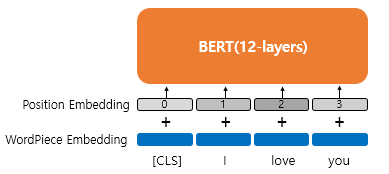  
- WordPiece Embedding은 우리가 이미 알고 있는 단어 임베딩으로 실제 입력 값임
- 이 입력에 포지션 임베딩을 통해서 위치 정보를 더해야 함
- 위치 정보를 위한 임베딩 층(Embedding layer)을 하나 더 사용함
  - 문장의 길이가 4라면 4개의 포지션 임베딩 벡터를 학습시킴. 그리고 BERT의 입력마다 다음과 같이 포지션 임베딩 벡터를 더해줌
    - 첫번째 단어의 임베딩 벡터 + 0번 포지션 임베딩 벡터
    - 두번째 단어의 임베딩 벡터 + 1번 포지션 임베딩 벡터
    - 세번째 단어의 임베딩 벡터 + 2번 포지션 임베딩 벡터
    - 네번째 단어의 임베딩 벡터 + 3번 포지션 임베딩 벡터
- 문장의 최대 길이를 512로 하고 있으므로 총 512개의 포지션 임베딩 벡터가 학습됨
- BERT에서는 총 두 개의 임베딩 층이 사용되고 단어 집합의 크기가 30,522개인 단어 벡터를 위한 임베딩 층과 문장의 최대 길이가 512이므로 512개의 포지션 벡터를 위한 임베딩 층으로 구성됨

BERT의 사전 훈련(Pre-training)  
1. 마스크드 언어 모델(Masked Language Model, MLM)  
- BERT는 사전 훈련을 위해서 입력 텍스트의 15%의 단어를 랜덤으로 마스킹함. 그리고 인공 신경망에게 이 가려진 단어들(Masked words)을 예측하도록 함
- 예를 들어 '나는 [MASK]에 가서 그곳에서 빵과 [MASK]를 샀다'를 주고 '슈퍼'와 '우유'를 맞추게 함
- 전부 [MASK]로 변경하지는 않고 랜덤으로 선택된 15%의 단어들은 다시 다음과 같은 비율로 규칙이 적용됨
  - 80%의 단어들은 [MASK]로 변경됨. Ex) The man went to the store → The man went to the [MASK]
  - 10%의 단어들은 랜덤으로 단어가 변경됨. Ex) The man went to the store → The man went to the dog
  - 10%의 단어들은 동일하게 구성됨. Ex) The man went to the store → The man went to the store
- 전체 단어 관점에서 적용되는 규칙
  - [MASK]만 사용할 경우에는 [MASK] 토큰이 파인 튜닝 단계에서는 나타나지 않으므로 사전 학습 단계와 파인 튜닝 단계에서의 불일치가 발생하는 문제가 있음. 이 문제을 완화하기 위해서 랜덤으로 선택된 15%의 단어들의 모든 토큰을 [MASK]로 사용하지 않음
  - 전체 단어의 85%는 마스크드 언어 모델의 학습에 사용되지 않음
  - 마스크드 언어 모델의 학습에 사용되는 단어는 전체 단어의 15%만 사용
  - 학습에 사용되는 12%는 [MASK]로 변경 후에 원래 단어를 예측함
  - 1.5%는 랜덤으로 단어가 변경된 후에 원래 단어를 예측함
  - 1.5%는 단어가 변경되지는 않았지만 BERT는 이 단어가 변경된 단어인지 원래 단어인지 알 수 없음. 이 경우에도 BERT는 원래 단어가 무엇인지를 예측하도록 함
- 예시
  - 'My dog is cute. he likes playing'이라는 문장에 대해서 마스크드 언어 모델을 학습하고자 할 때
  - 약간의 전처리와 BERT의 서브워드 토크나이저에 의해 이 문장은 ['my', 'dog', 'is' 'cute', 'he', 'likes', 'play', '##ing']로 토큰화가 되어 BERT의 입력으로 사용됨
  - 언어 모델 학습을 위해서 다음과 같이 데이터가 변경되었다고 가정
    - 'dog' 토큰은 [MASK]로 변경되었음  
    - 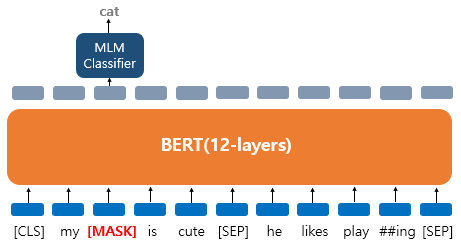  
    - 위 그림은 'dog' 토큰이 [MASK]로 변경되어서 BERT 모델이 원래 단어를 맞추려고 하는 모습
    - 여기서 출력층에 있는 다른 위치의 벡터들은 예측과 학습에 사용되지 않고 오직 'dog' 위치의 출력층의 벡터만이 사용됨
      - BERT의 손실 함수에서 다른 위치에서의 예측은 무시함
      - 출력층에서는 예측을 위해 단어 집합의 크기만큼의 Dense layer에 소프트맥스 함수가 사용된 1개의 층을 사용하여 원래 단어가 무엇인지를 맞추게 됨
  - 만약 'dog'만 변경된 것이 아니라 다음과 같은 세 가지 유형으로 데이터셋이 변경되었을 때의 동작  
  - 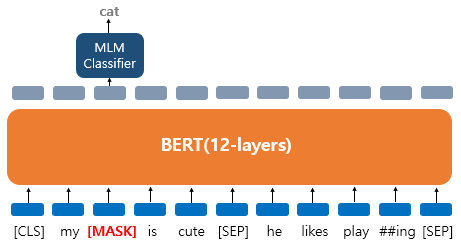  
    - 'dog' 토큰은 [MASK]로 변경됨
    - 'he'는 랜덤 단어 'king'으로 변경됨
    - 'play'는 변경되진 않았지만 예측에 사용됨  
    - 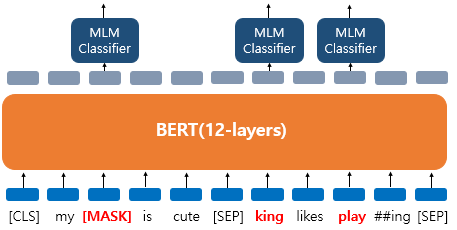  
    - BERT는 랜덤 단어 'king'으로 변경된 토큰에 대해서도 원래 단어가 무엇인지 또는 변경되지 않은 단어 'play'에 대해서도 원래 단어가 무엇인지를 예측해야 함
    - 'play'는 변경되지 않았지만 BERT 입장에서는 이것이 변경된 단어인지 아닌지 모르므로 원래 단어를 예측해야 함  

2. 다음 문장 예측(Next Sentence Prediction, NSP)  
- BERT는 두 개의 문장을 준 후에 이 문장이 이어지는 문장인지 아닌지를 맞추는 방식으로 훈련시킴
- 이를 위해서 50:50 비율로 실제 이어지는 두 개의 문장과 랜덤으로 이어붙인 두 개의 문장을 주고 훈련시킴
- 각각 Sentence A와 Sentence B라고 하였을 때, 다음의 예는 문장의 연속성을 확인한 경우와 그렇지 않은 경우를 보여줌
  - 이어지는 문장의 경우
    - Sentence A : The man went to the store.
    - Sentence B : He bought a gallon of milk.
    - Label = IsNextSentence
  - 이어지는 문장이 아닌 경우 경우
    - Sentence A : The man went to the store.
    - Sentence B : dogs are so cute.
    - Label = NotNextSentence  
  - 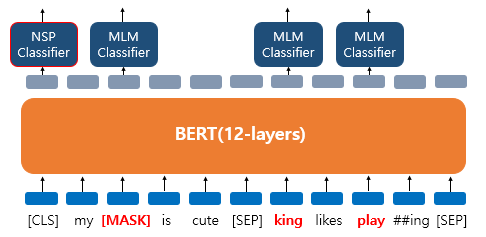  
- BERT의 입력으로 넣을 때에는 [SEP]라는 특별 토큰을 사용해서 문장을 구분함
- 첫번째 문장의 끝에 [SEP] 토큰을 넣고 두번째 문장이 끝나면 역시 [SEP] 토큰을 붙여줌
- 그리고 이 두 문장이 실제 이어지는 문장인지 아닌지를 [CLS] 토큰의 위치의 출력층에서 이진 분류 문제를 풀도록 함
- [CLS] 토큰은 BERT가 분류 문제를 풀기 위해 추가된 특별 토큰
- 마스크드 언어 모델과 다음 문장 예측은 따로 학습하는 것이 아닌 loss를 합하여 학습이 동시에 이루어짐

세그먼트 임베딩(Segment Embedding)  
- BERT는 QA 등과 같은 두 개의 문장 입력이 필요한 태스크를 풀기도 함
- 문장 구분을 위해서 BERT는 세그먼트 임베딩이라는 또 다른 임베딩 층(Embedding layer)을 사용함
  - 첫번째 문장에는 Sentence 0 임베딩, 두번째 문장에는 Sentence 1 임베딩을 더해주는 방식. 임베딩 벡터는 두 개만 사용
- 결론적으로 BERT는 총 3개의 임베딩 층을 사용함
  - WordPiece Embedding : 실제 입력 워드 임베딩. 임베딩 벡터의 종류는 단어 집합의 크기로 30,522개.
  - Position Embedding : 위치 정보를 학습하기 위한 임베딩. 임베딩 벡터의 종류는 문장의 최대 길이인 512개.
  - Segment Embedding : 두 개의 문장을 구분하기 위한 임베딩. 임베딩 벡터의 종류는 문장의 최대 개수인 2개.
- BERT가 문장 중간의 [SEP] 토큰과 두 종류의 세그먼트 임베딩을 통해서 두 개의 문장을 구분하여 입력받을 수 있다고 설명하고 있지만 여기서 BERT에 두 개의 문장이 들어간다는 표현에서의 문장이라는 것은 실제 우리가 알고 있는 문장의 단위는 아님
  - 예를 들어 QA 문제를 푸는 경우에는 [SEP]와 세그먼트 임베딩을 기준으로 구분되는 [질문(Question), 본문(Paragraph)] 두 종류의 텍스트를 입력받지만 Paragraph 1개는 실제로는 다수의 문장으로 구성될수 있음
  - [SEP]와 세그먼트 임베딩으로 구분되는 BERT의 입력에서의 두 개의 문장은 실제로는 두 종류의 텍스트, 두 개의 문서일 수 있음
- BERT가 두 개의 문장을 입력받을 필요가 없는 경우도 있음. 네이버 영화 리뷰 분류나 IMDB 리뷰 분류와 같은 감성 분류 태스크에서는 한 개의 문서에 대해서만 분류를 하는 것이므로 이 경우에는 BERT의 전체 입력에 Sentence 0 임베딩만을 더해줌

BERT를 파인 튜닝(Fine-tuning)하기  
1. 하나의 텍스트에 대한 텍스트 분류 유형(Single Text Classification)  
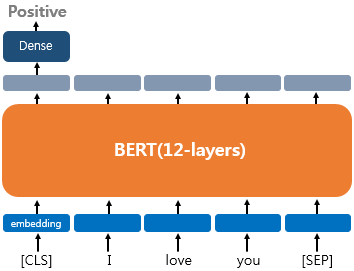  
- 텍스트 분류
- 영화 리뷰 감성 분류, 로이터 뉴스 분류 등과 같이 입력된 문서에 대해서 분류를 하는 유형
- 문서의 시작에 [CLS] 라는 토큰을 입력함
- 사전 훈련 단계에서 다음 문장 예측을 설명할 때 [CLS] 토큰은 BERT가 분류 문제를 풀기 위한 특별 토큰
  - 텍스트 분류 문제를 풀기 위해서 [CLS] 토큰의 위치의 출력층에서 밀집층(Dense layer) 또는 같은 이름으로는 완전 연결층(fully-connected layer)이라고 불리는 층들을 추가하여 분류에 대한 예측을 하게 됨
2. 하나의 텍스트에 대한 태깅 작업(Tagging)  
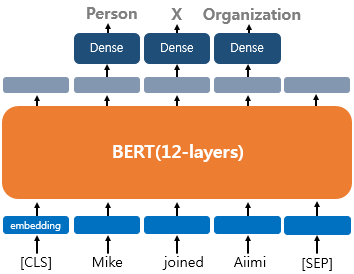  
- 태깅 작업
- 문장의 각 단어에 품사를 태깅하는 품사 태깅 작업과 개체를 태깅하는 개체명 인식 작업
- 출력층에서는 입력 텍스트의 각 토큰의 위치에 밀집층을 사용하여 분류에 대한 예측을 함
3. 텍스트의 쌍에 대한 분류 또는 회귀 문제(Text Pair Classification or Regression)  
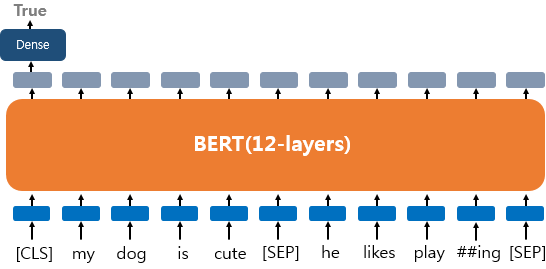  
- 텍스트의 쌍을 입력으로 받는 대표적인 태스크인 자연어 추론(Natural language inference) 문제는 두 문장이 주어졌을 때 하나의 문장이 다른 문장과 논리적으로 어떤 관계에 있는지를 분류하는 것
- 유형으로는 모순 관계(contradiction), 함의 관계(entailment), 중립 관계(neutral)가 있습니다.
- 텍스트의 쌍을 입력받는 이러한 태스크의 경우 입력 텍스트가 1개가 아니므로 텍스트 사이에 [SEP] 토큰을 집어넣고 Sentence 0 임베딩과 Sentence 1 임베딩이라는 두 종류의 세그먼트 임베딩을 모두 사용하여 문서를 구분함
4. 질의 응답(Question Answering. QA)  
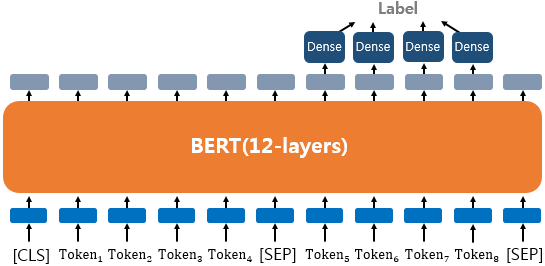  
- BERT로 QA를 풀기 위해서 질문과 본문이라는 두 개의 텍스트의 쌍을 입력함
- SQuAD 데이터셋을 푸는 방법은 질문과 본문을 입력받으면 본문의 일부분을 추출해서 질문에 답변하는 것
- 실제로 이 데이터셋은 영어로 되어있지만 한국어로 예시를 들면.
  - 질문 : "강우가 떨어지도록 영향을 주는 것은?"
  - 본문 : "기상학에서 강우는 대기 수증기가 응결되어 중력의 영향을 받고 떨어지는 것을 의미합니다. 강우의 주요 형태는 이슬비, 비, 진눈깨비, 눈, 싸락눈 및 우박이 있습니다."
  - 정답 : "중력"이 되어야 함
  
어텐션 마스크(Attention Mask)  
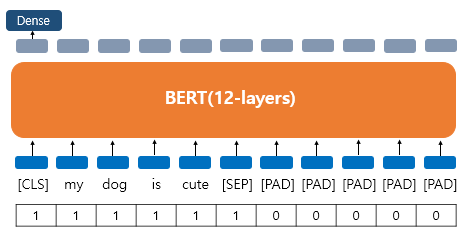  
- 어텐션 마스크라는 시퀀스 입력이 추가로 필요함
- 어텐션 마스크는 BERT가 어텐션 연산을 할 때 불필요하게 패딩 토큰에 대해서 어텐션을 하지 않도록 실제 단어와 패딩 토큰을 구분할 수 있도록 알려주는 입력
- 이 값은 0과 1 두 가지 값을 가지는데 숫자 1은 해당 토큰은 실제 단어이므로 마스킹을 하지 않는다라는 의미
  - 숫자 0은 해당 토큰은 패딩 토큰이므로 마스킹을 한다는 의미
  - 실제 단어의 위치에는 1, 패딩 토큰의 위치에는 0의 값을 가지는 시퀀스를 만들어 BERT의 또 다른 입력으로 사용

In [4]:
from transformers import TFBertForMaskedLM
from transformers import AutoTokenizer

model = TFBertForMaskedLM.from_pretrained('bert-large-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [13]:
inputs = tokenizer('Soccer is a really fun [MASK].', return_tensors='tf')
print(inputs['input_ids']) # 정수 인코딩
print(inputs['token_type_ids']) # 세그먼트 인코딩 결과
print(inputs['attention_mask']) # attention mask

tf.Tensor([[ 101 4715 2003 1037 2428 4569  103 1012  102]], shape=(1, 9), dtype=int32)
tf.Tensor([[0 0 0 0 0 0 0 0 0]], shape=(1, 9), dtype=int32)
tf.Tensor([[1 1 1 1 1 1 1 1 1]], shape=(1, 9), dtype=int32)


In [14]:
from transformers import FillMaskPipeline
pip = FillMaskPipeline(model=model, tokenizer=tokenizer)
pip('Soccer is a really fun [MASK].')

[{'score': 0.762112021446228,
  'token': 4368,
  'token_str': 'sport',
  'sequence': 'soccer is a really fun sport.'},
 {'score': 0.20341959595680237,
  'token': 2208,
  'token_str': 'game',
  'sequence': 'soccer is a really fun game.'},
 {'score': 0.012208596803247929,
  'token': 2518,
  'token_str': 'thing',
  'sequence': 'soccer is a really fun thing.'},
 {'score': 0.0018630301347002387,
  'token': 4023,
  'token_str': 'activity',
  'sequence': 'soccer is a really fun activity.'},
 {'score': 0.0013354877009987831,
  'token': 2492,
  'token_str': 'field',
  'sequence': 'soccer is a really fun field.'}]